## used mobilenets

In [1]:
#download dataset from github to the drive
!cd "drive/My Drive/Dataset"

In [2]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 15.07 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (658/658), done.


In [6]:
!ls

drive  sample_data  Sign-Language-Digits-Dataset


In [3]:
import os

In [4]:
os.chdir('../..')

In [5]:
os.chdir('content')

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

In [9]:
#used to set gpu
physical_devices=tf.config.experimental.list_physical_devices('GPU')
print('gpus: ',len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

gpus:  1


In [10]:
mobile=tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !kaggle -v

     |████████████████████████████████| 61kB 4.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=b4efd8dd63d334f3ebabf8fe1fb3a614d1f9e44908b3f644060049391915d912
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
#upload the credentials of the kaggle account
# from google.colab import files
# files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darshanmalaviya","key":"7fd1e3adf1dfbfca1962e79f8bdeb3e9"}'}

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d ardamavi/sign-language-digits-dataset

 54% 9.00M/16.8M [00:00<00:00, 10.8MB/s]
100% 16.8M/16.8M [00:00<00:00, 17.7MB/s]


In [ ]:
# from zipfile import ZipFile
# fname='sign-language-digits-dataset.zip'
# with ZipFile(fname,'r') as zip:
#   zip.extractall()
#   print('done')

done


In [11]:
#organize data into train,test and valid
os.chdir('Dataset')
if os.path.isdir('train/0/') is False:
  os.mkdir('train')
  os.mkdir('valid')
  os.mkdir('test')

  for i in range(0,10):
    shutil.move(f'{i}','train')
    os.mkdir(f'valid/{i}')
    os.mkdir(f'test/{i}')

    valid_samples=random.sample(os.listdir(f'train/{i}'),30)
    for j in valid_samples:
      shutil.move(f'train/{i}/{j}',f'valid/{i}')

    test_samples=random.sample(os.listdir(f'train/{i}'),5)
    for k in test_samples:
      shutil.move(f'train/{i}/{k}',f'test/{i}')

In [12]:
!ls

test  train  valid


In [13]:
os.chdir('../')

In [14]:
train_path='Dataset/train'
test_path='Dataset/test'
valid_path='Dataset/valid'

In [ ]:
#now preprocess data

In [15]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
  .flow_from_directory(directory=train_path,target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
  .flow_from_directory(directory=valid_path,target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
  .flow_from_directory(directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [17]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [18]:
x=mobile.layers[-6].output
output=Dense(units=10,activation='softmax')(x)

In [20]:
from tensorflow.keras import Model

In [23]:
model=Model(inputs=mobile.input,outputs=output)

In [24]:
for layer in model.layers[:-23]:
  layer.trainable=False

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=30,verbose=2)

Epoch 1/30
172/172 - 8s - loss: 0.6426 - accuracy: 0.8166 - val_loss: 0.3361 - val_accuracy: 0.8800
Epoch 2/30
172/172 - 7s - loss: 0.1138 - accuracy: 0.9848 - val_loss: 0.2013 - val_accuracy: 0.9200
Epoch 3/30
172/172 - 7s - loss: 0.0518 - accuracy: 0.9965 - val_loss: 0.1140 - val_accuracy: 0.9667
Epoch 4/30
172/172 - 7s - loss: 0.0322 - accuracy: 0.9959 - val_loss: 0.0986 - val_accuracy: 0.9633
Epoch 5/30
172/172 - 7s - loss: 0.0205 - accuracy: 0.9988 - val_loss: 0.0651 - val_accuracy: 0.9767
Epoch 6/30
172/172 - 7s - loss: 0.0183 - accuracy: 0.9994 - val_loss: 0.0593 - val_accuracy: 0.9800
Epoch 7/30
172/172 - 7s - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9833
Epoch 8/30
172/172 - 7s - loss: 0.0115 - accuracy: 0.9988 - val_loss: 0.0499 - val_accuracy: 0.9767
Epoch 9/30
172/172 - 7s - loss: 0.0090 - accuracy: 0.9988 - val_loss: 0.0436 - val_accuracy: 0.9833
Epoch 10/30
172/172 - 7s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.9900

In [28]:
test_labels=test_batches.classes

In [29]:
predictions=model.predict(x=test_batches,verbose=0)

In [30]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes,rotation=0)

  if normalize:
    cm=cm.astype('float')/am.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix,without normalization")
  
  print(cm)

  thresh=cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],horizontalalignment='center',color='white' if cm[i,j]>thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [31]:
cm=confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

In [32]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix,without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


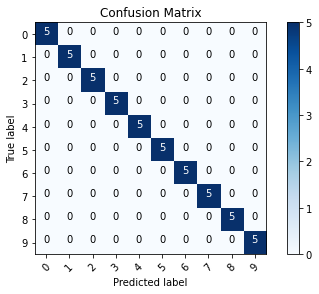

In [33]:
cm_plot_labels=['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [34]:
model.save('signlan_pred.h5')